In [1]:
from bitcoin_listener import OrderBook
import bitcoin_listener as btcl

In [2]:
o = OrderBook(exchange='bitstamp')

In [3]:
o.fetch_one()

In [4]:
#o.flush_orderbook()

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# from list of dates read file
# read ask-bid-vol
# read ask-bid-orderbook til n/vol/...
# read ask-bid and estimate params
# save summary on database

In [6]:
#technical analysis

In [7]:
from bitcoin_listener import OrderBook
import os
import gzip
import bitcoin_listener as btcl
source_orderbook = btcl.config['DEFAULT']['source_orderbook']
#source_orderbook = '/home/eol/Documents/bitcoin_compress/orderbook/'


def read_dates(exchange):
    if exchange not in OrderBook.EXCHANGES.keys():
        return []
    p = os.path.join(source_orderbook, exchange)
    return sorted([
        ".".join(f.split(".")[:-1]) for f in os.listdir(p)
        if os.path.isfile(os.path.join(p, f))
    ])

print(read_dates('bitstamp'))

def read_file(exchange, date):
    if exchange not in OrderBook.EXCHANGES.keys():
        return ""
    if date not in read_dates(exchange):
        return ""
    
    p = os.path.join(source_orderbook, exchange, "{}.gz".format(date))
    
    file_text = ""
    with gzip.open(p,'r') as gf: 
        file_text = gf.read().decode('utf-8')
    return file_text

print(read_file('bitstamp', '2018-05-19')[:100])

['2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21']
1526688176|6968 12362|825179,667e4 8,215e5 12,188e4 259,141e5 2,121e5 120,204e5 420,5e7 170,5e7 34,4


In [8]:
import numpy as np
import datetime as dt
def get_orderbook(exchange, date, lim_orderbook=None):
    if exchange not in OrderBook.EXCHANGES.keys():
        return {}
    if date not in read_dates(exchange):
        return {}
    
    adj_price = OrderBook.EXCHANGES[exchange]['best_shift']['price']
    adj_amount = OrderBook.EXCHANGES[exchange]['best_shift']['amount']
    
    text = read_file(exchange, date)
    
    lines = [l for l in text.split('\n') if l]
    s = len(lines)
    
    data = np.ndarray(s, dtype=np.dtype([
            ('epoch', dt.datetime), 
            ('ask', np.dtype([('price', float),('qtd', 'uint')])), 
            ('bid', np.dtype([('price', float),('qtd', 'uint')])), 
            ('orderbook', np.dtype([('ask', np.ndarray),('bid', np.ndarray)]))
        ]))
    
    for i in range(s):
        
        d = lines[i].split('|')
        
        data[i]['epoch'] = dt.datetime.fromtimestamp(int(d[0]))
        
        qtd_askbid = [float(v) for v in d[1].split(' ')]
        data[i]['ask']['qtd'] = qtd_askbid[0]
        data[i]['bid']['qtd'] = qtd_askbid[1]
        
        list_asks = d[2].split(' ')[:lim_orderbook]
        oask = np.ndarray(len(list_asks), dtype=[('price', float), ('amount', float)])
        oask['price'] = np.cumsum([float(p.split(',')[0])/10**adj_price for p in list_asks])
        oask['amount'] = [float(p.split(',')[1])/10**adj_amount for p in list_asks]
        data[i]['ask']['price'] = oask['price'][0]
        data[i]['orderbook']['ask'] = oask

        list_bids = d[3].split(' ')[:lim_orderbook]
        obid = np.ndarray(len(list_bids), dtype=[('price', float), ('amount', float)])
        obid['price'] = np.cumsum([float(p.split(',')[0])/10**adj_price for p in list_bids])
        obid['amount'] = [float(p.split(',')[1])/10**adj_amount for p in list_bids]
        data[i]['bid']['price'] = obid['price'][0]
        data[i]['orderbook']['bid'] = obid
        
    return data

x = get_orderbook('bitstamp', '2018-05-21', 5000)

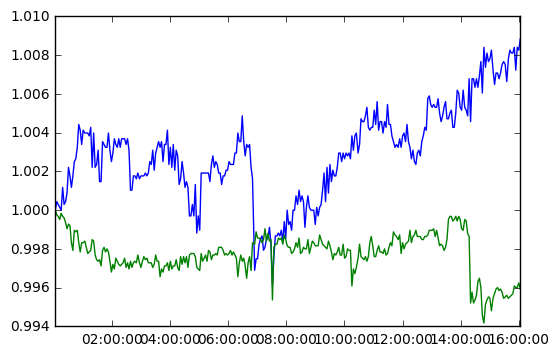

In [9]:
plt.plot(x['epoch'],x['ask']['qtd']/x['ask']['qtd'][0])
plt.plot(x['epoch'],x['bid']['qtd']/x['bid']['qtd'][0])

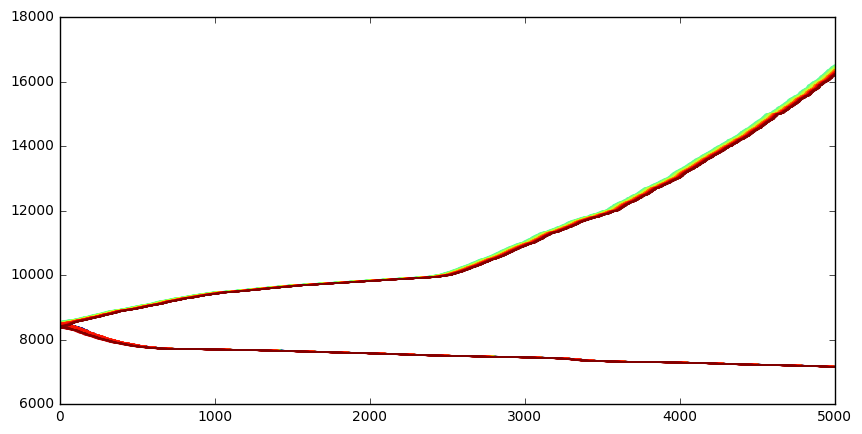

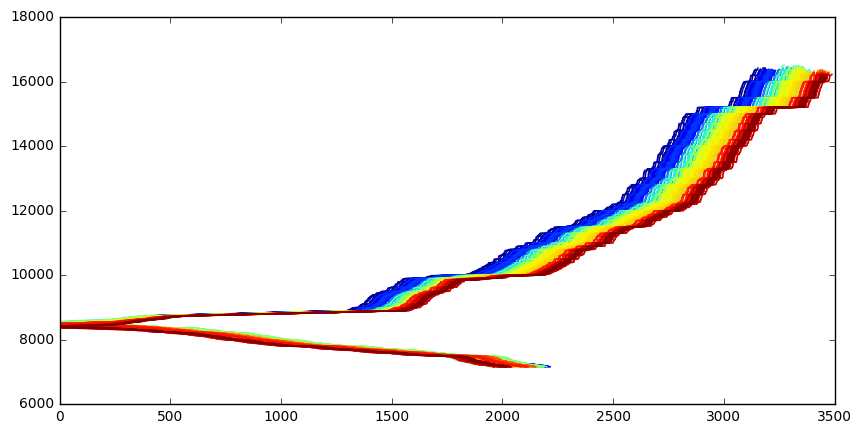

In [10]:
N = 0
X = x.size

hsv = plt.get_cmap('jet')
colors = hsv(np.linspace(0, 1.0, X))

plt.figure(figsize=(10,5))
for i in range(X-N):
    plt.plot(x[i+N]['orderbook']['ask']['price'], color=colors[i])
    plt.plot(x[i+N]['orderbook']['bid']['price'], color=colors[i])
plt.show()
plt.figure(figsize=(10,5))
for i in range(X-N):
    plt.plot(np.cumsum(x[i+N]['orderbook']['ask']['amount']),x[i+N]['orderbook']['ask']['price'], color=colors[i])
    plt.plot(np.cumsum(x[i+N]['orderbook']['bid']['amount']),x[i+N]['orderbook']['bid']['price'], color=colors[i])
plt.show()

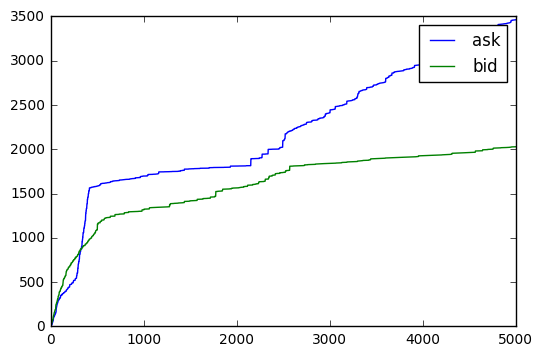

In [11]:
plt.plot(np.cumsum(x[i+N]['orderbook']['ask']['amount']), label='ask')
plt.plot(np.cumsum(x[i+N]['orderbook']['bid']['amount']), label='bid')
plt.legend()